<a href="https://colab.research.google.com/github/NikolaevMikhailRoma/Other-Projects/blob/main/Multitask_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess

## imports

In [1]:
# imports
! pip install git+https://github.com/rcmalli/keras-vggface.git

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

from tensorflow.keras.preprocessing import image

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-mxs57g7s
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-mxs57g7s
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=f5fc33b7fc1ba183b714db9eb67b1f25f1736ba1ef51c2c467f9e05cf1396a7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-m1gnvt3b/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:00, 213MB/s]


## Load training data

In [2]:
from pathlib import Path
from collections import Counter

url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        # print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:00, 135MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 74.4MB/s]


23708
['26_1_2_20170116183016628.jpg.chip.jpg', '1_0_2_20161219211505437.jpg.chip.jpg', '30_1_1_20170117133827950.jpg.chip.jpg']
4759 18946


Let's make sure the class labels are correct:

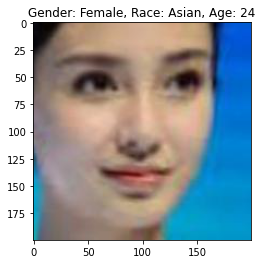

In [3]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Let's look at their distribution:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


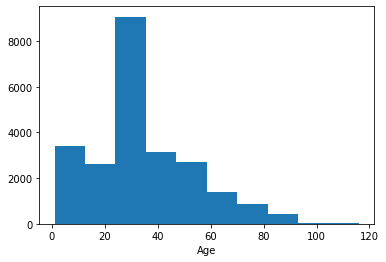

In [4]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## support functions and imports for train CONNECT GOOGLE DRIVE

In [12]:
#supporting code
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

# Connect google drive
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive/')


### for date generator
#image_gen должен содержать ImageDataGenerator с правильной preprocessing_function
def preprocess_input_facenet(image_):
    x = image.img_to_array(image_)
    x = np.expand_dims(x, axis=0)
    preprocessed = utils.preprocess_input(x, version=2)
    return preprocessed

image_gen = ImageDataGenerator(preprocess_input_facenet)

BATCH_SIZE = 128
IMAGE_SIZE = 224
###

### base model
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False #заморозка базовой модели
###

### for visualization
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # x_temp = np.copy(vggface_image)

    # x_temp[:, :, 2] += 131.0912
    # x_temp[:, :, 1] += 103.8827
    # x_temp[:, :, 0] += 91.4953

    # x_temp = x_temp[:, ::-1, ...]
    # x_temp = x_temp.astype(int)
    # в таком случае изображение получается осветлённым, вроде всё по инструкции

    # просто перевожу тип в integer

    # x_temp = np.copy(vggface_image)

    x_temp = vggface_image.astype(int)

    return x_temp
###

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Simple models

## 1.1 Create gender prediction model: data generator, constuct model and train

### a) data generator

In [6]:
train_generator = image_gen.flow_from_dataframe(dataframe= df_train, 
                                                directory=str(data_folder),
                                                x_col = 'img_name',
                                                y_col = 'gender',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = "binary", 
                                                shuffle = True)

val_generator = image_gen.flow_from_dataframe(dataframe= df_val,
                                              directory=str(data_folder),
                                              x_col = 'img_name',
                                              y_col = 'gender',
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode = "binary",
                                              shuffle = False)

# Check
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0, 1], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.
Simple tests passed


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


### b) building model

In [7]:
model_gender = tf.keras.Sequential([
                                    base_model,
                                    
                                    tf.keras.layers.Dense(1, activation='sigmoid')]) 

model_gender.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gender.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


### c) train

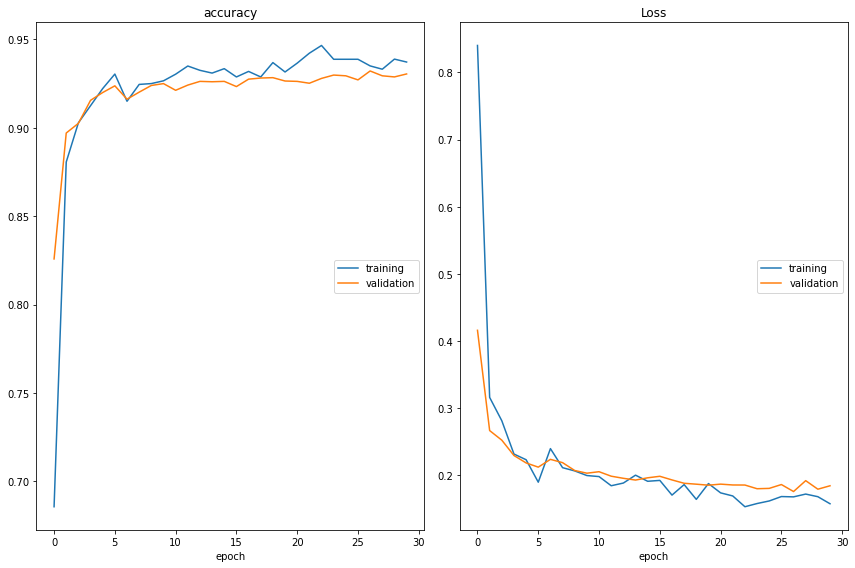

accuracy
	training         	 (min:    0.686, max:    0.947, cur:    0.937)
	validation       	 (min:    0.826, max:    0.932, cur:    0.930)
Loss
	training         	 (min:    0.153, max:    0.840, cur:    0.158)
	validation       	 (min:    0.176, max:    0.416, cur:    0.185)

Epoch 00030: val_accuracy did not improve from 0.93213


In [8]:
# Connect google drive
path = Path("/content/drive/My Drive/Skillbox/model_2")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "model_gender/checkpoint_best.h5"  
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

epochs=30
steps_per_epoch=50

model_gender.fit(x = train_generator, validation_data=val_generator, epochs=epochs,  steps_per_epoch=steps_per_epoch, verbose=1, callbacks=[PlotLossesCallback(), checkpoint])

### Result

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


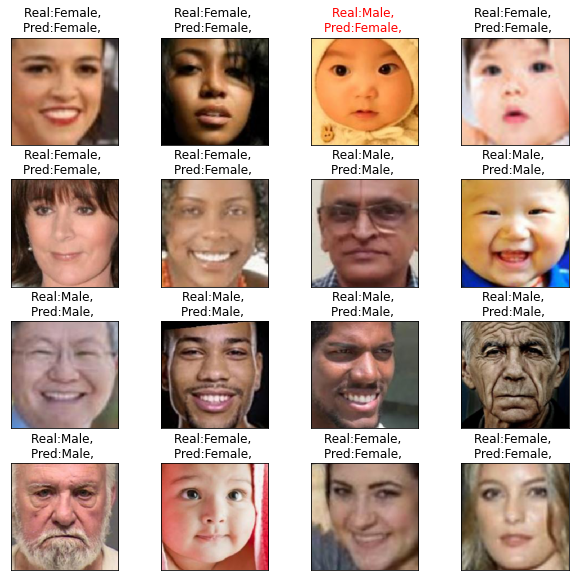

In [25]:
# We can visualize the result
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

Fail image
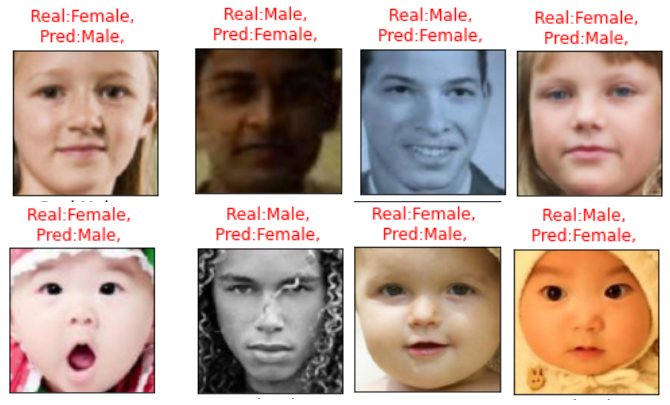

## 1.2 Create gender prediction model: data generator, constuct model and train



### a) data generator

In [26]:
train_generator = image_gen.flow_from_dataframe(dataframe= df_train, 
                                                directory=str(data_folder),
                                                x_col = 'img_name',
                                                y_col = 'race',
                                                target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = "sparse", 
                                                shuffle = True)

val_generator = image_gen.flow_from_dataframe(dataframe= df_val,
                                              directory=str(data_folder),
                                              x_col = 'img_name',
                                              y_col = 'race',
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode = "sparse",
                                              shuffle = False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


### b) build and fit model

In [27]:
model_race = tf.keras.Sequential([base_model, 
                                  tf.keras.layers.Dense(5, activation='sigmoid')])

model_race.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_race.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,571,397
Trainable params: 10,245
Non-trainable params: 23,561,152
_________________________________________________________________


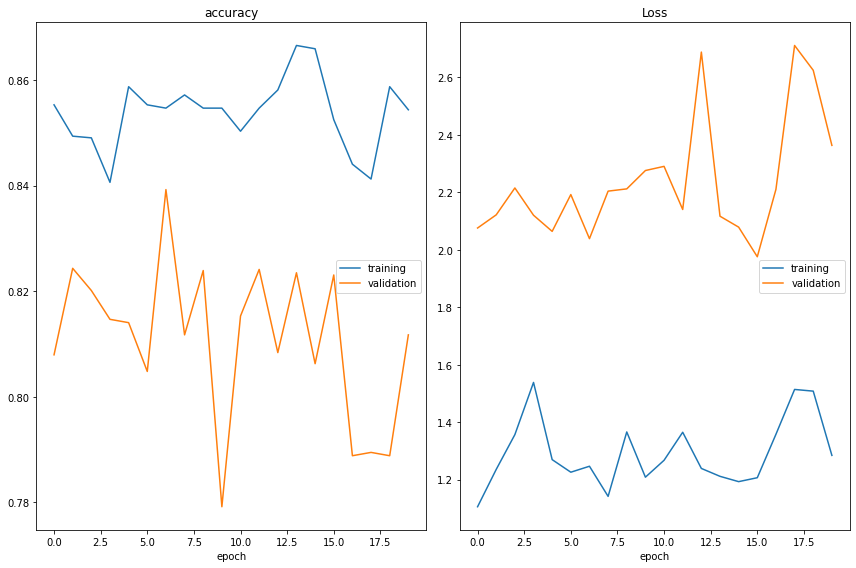

accuracy
	training         	 (min:    0.841, max:    0.867, cur:    0.854)
	validation       	 (min:    0.779, max:    0.839, cur:    0.812)
Loss
	training         	 (min:    1.106, max:    1.538, cur:    1.285)
	validation       	 (min:    1.976, max:    2.711, cur:    2.363)

Epoch 00020: val_accuracy did not improve from 0.83925


In [29]:
path = Path("/content/drive/My Drive/Skillbox/model_2")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "model_race/checkpoint_best.h5"  
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

epochs=20
steps_per_epoch=50

#думаю лучше так, более новое представление для генератора
model_race.fit(x = train_generator, validation_data=val_generator, epochs=epochs,  steps_per_epoch=25, verbose=1, callbacks=[PlotLossesCallback(), checkpoint])

### c)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


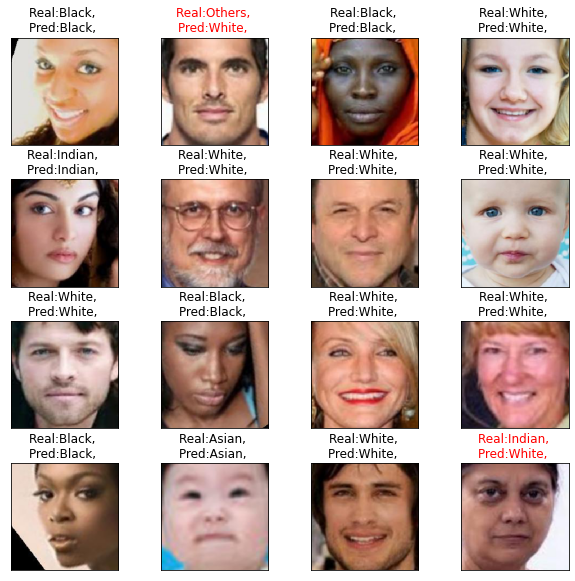

In [30]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

# 2. Multitask learning

С помощью мультитаска можно обработать множество выходных слоёв и сделать прикидки, использую для повышения своих скилов. В первой ячейке планируется добавить функции для автоматизации процесса добавления новых выходов для модели (пока не реализованно)

In [34]:
# y_coll = []
# func_labels = def() ### add to split_outputs
# metrics = [] #
# loss = [] # 


In [35]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="multi_output",
        x_col="img_name", y_col=["gender", "race", "age"], #!
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="multi_output",
        x_col="img_name", y_col=["gender", "race", "age"], #!
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)

def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.
    """
    while True:
        data = next(generator)
        image = data[0]

        ### !!! В зависимости от типа данных небходимо преобразовать форматы. (object не пойдёт) 
        # В категориальных признаках нужен формат 'int', !!!не флоат!!!, 'int'
        # А возраст у нас нормирован [0, 1], !Посмотреть распределение сырых значений на первом df, чуйка!
        labels = list((np.array(data[1][0]).astype("int"), np.array(data[1][1]).astype("int"),np.array(data[1][2]).astype("float32")))
        yield image, labels

a, b = next(split_outputs(val_generator))

Found 18946 validated image filenames.
Found 4759 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 2048)         23561152    input_1[0][0]                    
__________________________________________________________________________________________________
Layer4 (Dense)                  (None, 64)           131136      model_2[1][0]                    
__________________________________________________________________________________________________
Layer5 (Dense)                  (None, 32)           2080        Layer4[0][0]                     
____________________________________________________________________________________________

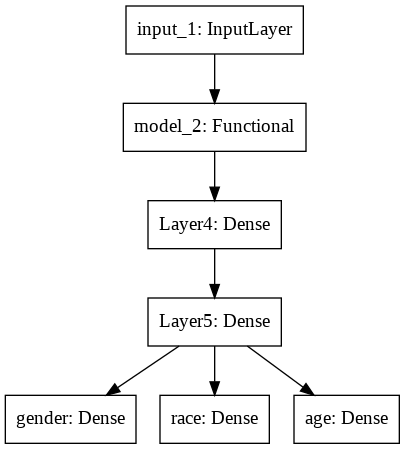

In [36]:
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
Layer1 = base_model(input_layer)

# Layer2 = tf.keras.layers.Dense(128, name = 'Layer2')(Layer1)
# Layer3 = tf.keras.layers.Dense(64, name = 'Layer3')(Layer1) # правка Layer1 -> Layer2 потом, но давайте оставим 64
# Layer2 = tf.keras.layers.Dense(512, name = 'Layer2', activation='relu')(Layer1)
# Layer3 = tf.keras.layers.Dense(256, name = 'Layer3', activation='relu')(Layer2)
Layer4 = tf.keras.layers.Dense(64, name = 'Layer4', activation='relu')(Layer1)
Layer5 = tf.keras.layers.Dense(32, name = 'Layer5', activation='relu')(Layer4)


#! расставить оутпуты
gender_output = tf.keras.layers.Dense(1, name = 'gender', activation = 'sigmoid')(Layer5)
race_output = tf.keras.layers.Dense(5, name = 'race', activation = 'sigmoid')(Layer5)
age_output = tf.keras.layers.Dense(1, name = 'age', activation = 'sigmoid')(Layer5)

model = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])

model.summary()
plot_model(model)

In [37]:
# prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
# assert len(prediction) == 3, "Модель должна возвращать три тензора"
# assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
# assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
# assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
# print("Shape tests passed")

In [38]:
path = Path("/content/drive/My Drive/Skillbox/model_2")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()
cpt_filename = "model_multitask/checkpoint_best.h5"  
cpt_path =str(path / cpt_filename)

А теперь перейдем к обучению:

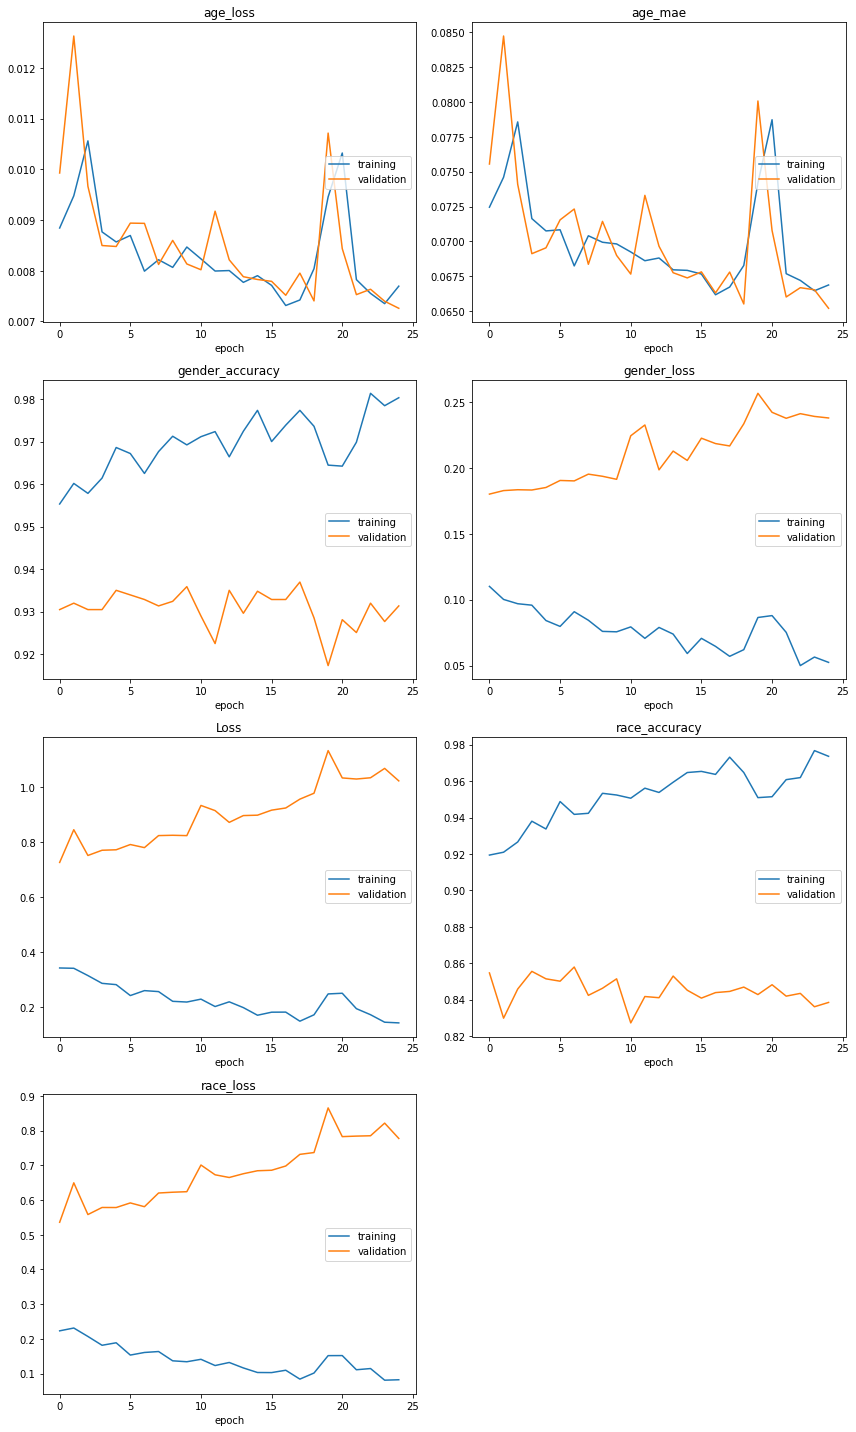

age_loss
	training         	 (min:    0.007, max:    0.011, cur:    0.008)
	validation       	 (min:    0.007, max:    0.013, cur:    0.007)
age_mae
	training         	 (min:    0.066, max:    0.079, cur:    0.067)
	validation       	 (min:    0.065, max:    0.085, cur:    0.065)
gender_accuracy
	training         	 (min:    0.955, max:    0.981, cur:    0.980)
	validation       	 (min:    0.917, max:    0.937, cur:    0.931)
gender_loss
	training         	 (min:    0.050, max:    0.110, cur:    0.052)
	validation       	 (min:    0.180, max:    0.257, cur:    0.238)
Loss
	training         	 (min:    0.143, max:    0.342, cur:    0.143)
	validation       	 (min:    0.726, max:    1.132, cur:    1.022)
race_accuracy
	training         	 (min:    0.919, max:    0.977, cur:    0.974)
	validation       	 (min:    0.827, max:    0.858, cur:    0.838)
race_loss
	training         	 (min:    0.081, max:    0.231, cur:    0.082)
	validation       	 (min:    0.536, max:    0.865, cur:    0.777)


In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'}, #!
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'}) #!

# checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, metrics = 'rase_accurasy', verbose=1, save_best_only=True, mode='max') # критерий по возрасту проводим, да
checkpoint =  tf.keras.callbacks.ModelCheckpoint(cpt_path)
epochs=25
steps_per_epoch=50

model.fit_generator(split_outputs(train_generator), validation_data=split_outputs(val_generator), 
                    callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=steps_per_epoch, epochs=epochs,
                    validation_steps= len(df_val) // BATCH_SIZE) 

In [41]:
# check cpt_path!!!
# model_multitask_cpt_path = cpt_path
# model_multitask = load_model(cpt_path)
# val_generator = image_gen.flow_from_dataframe(
#         dataframe=df_val,
#         class_mode="multi_output",
#         x_col="img_name", y_col=["gender", "race", "age"], 
#         directory=str(data_folder),
#         target_size=(IMAGE_SIZE, IMAGE_SIZE),
#         batch_size=BATCH_SIZE,
#         shuffle=True)
# results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
# assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
# assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
# assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
# print("Well done!")

Found 4759 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


37/37 [==============================] - 8s 203ms/step - loss: 1.0249 - gender_loss: 0.2370 - race_loss: 0.7807 - age_loss: 0.0072 - gender_accuracy: 0.9312 - race_accuracy: 0.8383 - age_mae: 0.0652
Well done!


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


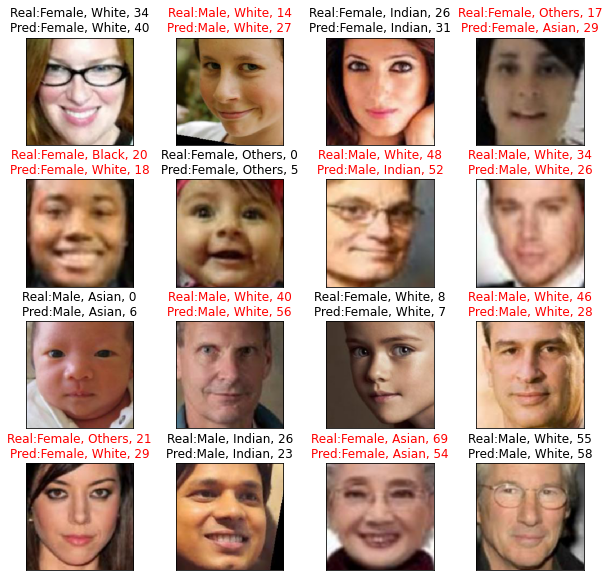

In [42]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

# Финалочка добавляем картинку и получаем результат

In [43]:
from PIL import Image
!pip install keras_applications #необходимо для keras_vggface units
from keras_vggface import utils

     |████████████████████████████████| 51kB 2.7MB/s 


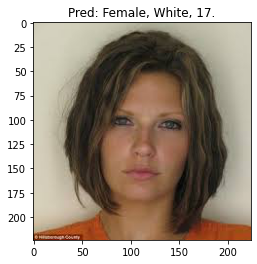

In [45]:
# url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
# output = 'me.jpg'
# gdown.download(url, output, quiet=False)
# model - добавить модель сетки
model = load_model(model_multitask_cpt_path)

img = image.load_img("images.jfif", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0] #!
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}." #!
_ = plt.title(title_obj)